<a href="https://colab.research.google.com/github/Praveen76/Text-Classification-using-BERT-Model/blob/main/Text_Classification_using_BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, you will be able to:

- load a BERT model from TensorFlow Hub
- build your own model by combining BERT with a classifier
- train your own model by fine-tuning BERT on IMDB dataset
- save your model and use it to perform sentiment analysis

## Dataset Description

The [IMDB Movie Reviews dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. The dataset contains an even number of positive and negative reviews. Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. The dataset contains additional unlabeled data.

## Introduction

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP. They compute **vector-space representations** of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name:

**B**idirectional **E**ncoder **R**epresentations from **T**ransformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks like:

- Sentence Pair Classification
- Single Sentence Classification
- Question Answering
- Single Sentence Tagging
<br><br>

<center>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/bert_tasks.png' width = 700px>

<br>

### Install dependencies

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip -q install "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cup

You can ignore the above warning. It is regarding the typing-extension package's version conflict among other libraries.

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip -q install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.2 MB/s eta 0:00:00


### Import required packages

In [4]:
import os
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization     # to create AdamW optimizer

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
# Download the dataset
  # http://ai.stanford.edu/~amaas/data/sentiment/ IMDB 50K

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 12s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random `seed`, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # -1, level of parallelism to use to the tf.data runtime
batch_size = 128 # hyperparameter
seed = 42

# For training, 20K
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                          batch_size=batch_size,
                                                          validation_split=0.2,
                                                          subset='training',
                                                          seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# For validation, 5K
val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                    batch_size=batch_size,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# For testing, 25K
test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                     batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [ ]:
# have a look at the instances (reviews) from the dataset

for text_batch, label_batch in train_ds.take(1): #enemurate , batch
    for i in range(5):
        # print(label_batch[i])
        print(f'Review: {text_batch.numpy()[i]}')           # tensor to numpy array
        print("lenght ", len(text_batch.numpy()[i]))
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})\n')  # class

Review: b"CAROL'S JOURNEY is a pleasure to watch for so many reasons. The acting of Clara Lago is simply amazing for someone so young, and she is one of those special actors who can say say much with facial expressions. Director Imanol Urbibe presents a tight and controlled film with no break in continuity, thereby propelling the plot at a steady pace with just enough suspense to keep one wondering what the nest scene will bring. The screenplay of Angel Garcia Roldan is story telling at its best, which, it seems, if the major purpose for films after all. The plot is unpredictable, yet the events as they unravel are completely logical. Perhaps the best feature of this film if to tell a story of the Spanish Civil War as it affected the people. It was a major event of the 20th century, yet hardly any Americans know of it. In fact, in 40 years of university teaching, I averaged about one student a semester who had even heard of it, much less any who could say anything comprehensive about i

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune.

There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.
<br><br>

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

In the code below, switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

Select `small_bert/bert_en_uncased_L-2_H-128_A-2` and run the below cell.

L=2, H=128, A=12 where L is the number of stacked encoders, H is the hidden size and A is the number of heads in the MultiHead Attention layers. Larger these values larger the model and more compute-intensive.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocess Text using Preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model.
>For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
 # Sample input text
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')      # ids for each word upto 128
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')          # mask for the input sentence
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized.
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, it can be included in your model directly.

### Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')             # number of features
print(f'Pooled Outputs Values: {bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')         # connection matrix for features 128x128
print(f'Sequence Outputs Values: {bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape: (1, 128)
Pooled Outputs Values: [-0.9999945   0.14341968 -0.998978    0.9951449  -0.9997457   0.9131292
 -0.9961582  -0.9709752   0.0974001   0.01907069 -0.8488175  -0.09385536]
Sequence Outputs Shape: (1, 128, 128)
Sequence Outputs Values: [[-0.4372365  -1.0138301  -2.374475   ... -0.7589705  -2.0910313
  -0.25809926]
 [-1.3369718  -0.36880213  0.57868755 ... -2.1810164  -1.7530917
  -0.09555079]
 [-1.0607058  -0.30370995  0.34461257 ... -1.2898587  -1.9519889
  -0.12230287]
 ...
 [-0.860227   -0.54406184  0.6583737  ... -1.4765681  -1.7518607
   1.1197375 ]
 [-0.4686899  -0.57152385  0.6725658  ... -1.730234   -1.9740782
   0.9747929 ]
 [ 0.0203663  -0.7551188   0.59482384 ... -1.9656774  -1.9051418
   0.48970175]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note:
>For more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, there is no need because the preprocessing model will take care of it.


In [ ]:
# Define a function to create custom classifier model using BERT

def build_classifier_model():

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')          # input layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # text processing (text to numbers)
    encoder_inputs = preprocessing_layer(text_input)                                    # one array to three array(mask, ids, sentence ids)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # define encoding layer
    outputs = encoder(encoder_inputs)                                                   # encoding
    net = outputs['pooled_output']                                                      # input array for the classification model
    net = tf.keras.layers.Dropout(0.1)(net)                                        # drouput layer
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)              # classification

    return tf.keras.Model(text_input, net)

In [ ]:
# Custom classifier model
classifier_model = build_classifier_model()

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
# Predction/classification using pretrained model

text_test = ['this is such a horrible movie!']        # sample input
bert_raw_result = classifier_model(tf.constant(text_test))     # pretrained model

print(tf.sigmoid(bert_raw_result))       # apply sigmoid to keep the output within 0 to 1

tf.Tensor([[0.6342396]], shape=(1, 1), dtype=float32)


The output is meaningless because the model has not been trained yet.

Let's take a look at the model's structure.

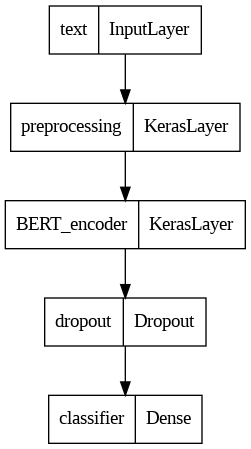

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

#### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
# Define loss function and metric
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

#### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
# Hyperparameters
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

#### Loading the BERT model and training

Using the `classifier_model` created earlier, compile the model with the loss, metric and optimizer.

In [ ]:
# Compile model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model selected.

In [ ]:
# Train the model
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
 58/157 [==========>...................] - ETA: 3:43 - loss: 0.7311 - binary_accuracy: 0.5081

### Evaluate the model

In [ ]:
# Predection on test dataset
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
# Visualize loss and accuracy for training and validation sets

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Inference

In [ ]:
# Save model for later use
saved_model_path = 'imdb_bert'
classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
# Load the saved model
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# Test your model on example sentences
# using both untuned and finetuned classifier model

def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is such a horrible movie!'
]

# Prediction using the Untuned classifier model
untuned_classifier_model = build_classifier_model()
untuned_results = tf.sigmoid(untuned_classifier_model(tf.constant(examples)))

# Prediction using finetuned classifier model
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print('Results from the untuned model:')
print_my_examples(examples, untuned_results)

print('Results from the finetuned model:')
print_my_examples(examples, reloaded_results)

### References

- https://www.tensorflow.org/text/tutorials/classify_text_with_bert